In [40]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp

from scipy.optimize import fsolve

from assimulo.solvers import IDA
from assimulo.problem import Implicit_Problem
import matplotlib.pyplot as plt
from assimulo.exception import TerminateSimulation


%matplotlib inline

##  Toy Battery Model
An ideal voltage source whose voltage is a function of depth of discharge in series with a resistor in series with a resistor/capacitor block.
<img src="./circuit_export.png" width="40%">

The voltage across capacitor is given by,
$$\frac{dV_c}{dt} = \frac{-V_c}{R_1 C_1} - \frac{I}{C_1}$$

$$V = U - V + I R_0$$

Here, $U$ is the open circuit potential which is afunction of depth of discharge.  The depth of discharge is given by,
$$\frac{d\quad dod}{dt} = \frac{-I}{3600 \times \mbox{Cell Capacity}}$$

Possible constraints:
Current is a constant, $$I = I_0$$
power is a constant, $$P = IV = P_0$$

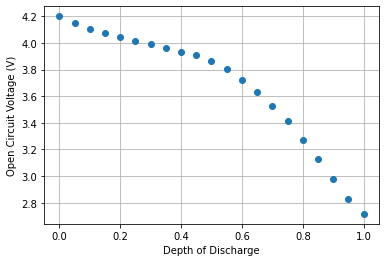

In [41]:
#  Define data points for our open circuit potential.
OCP_values = np.array( [4.200, 4.147, 4.107, 4.073, 4.041, 4.012, 3.988, 3.960, 3.935, 3.908, 3.865, 3.802, 3.724, 3.633, 3.529, 3.410, 3.274, 3.128, 2.979, 2.829, 2.716] )
dod_values = np.arange(0, 1.05, 0.05)

#  Plot the OCP just to get a feel of how it changes with depth of discharge
plt.plot(dod_values, OCP_values, 'o')
plt.xlabel('Depth of Discharge')
plt.ylabel('Open Circuit Voltage (V)')
plt.grid(True)

#  Create a spline object so we can interpolate to get a value at any valid depth of discharge
V_ocp = CubicSpline(dod_values, OCP_values)

##  Problem
1)  Generate voltage as a function of time for a one hour discharge at a constant current of 1 A<br>
2)  Generate voltage as a function of time for a one hour constant power discharge of -3.5 W.

###  Constant Current - solve_ivp

Our constrain is $I_0 = $ constant.

In [42]:
class CC_ODE:
    
    #  Set values of the resistances and capacitance
    R0 = 0.050
    R1 = 0.040
    C1 = 3000
    
    #  Set the cell capacity
    capacity = 1.5
    
    def __init__(self, tspan, I):
        self.I = I
        
        #  Set the initial value of the capacitor voltage
        V_c0 = np.array([0])
        
        #  Solve the ODE and bind the solution object to the class varable sol
        self.sol = solve_ivp(self.equations, (tspan[0], tspan[-1]), V_c0, t_eval = tspan)
        self.Vc = self.sol.y
        
        #  Get the soultion times
        self.t = self.sol.t
        
        #  Calculate the depth of discharge
        self.dod =  -I * self.t / 3600 / self.capacity
        
        #  Calculate the open circuit voltage
        self.U_ocp = V_ocp(self.dod)
        
        #  Calculate coltage and transpose it so it has the same shape as the time vector
        self.V =self. U_ocp - self.Vc + self.I * self.R0
        self.V = np.transpose(self.V)
    
    #  Define our differential equation.  The function is of the form
    #  xprime = f(t, x)
    def equations(self, t, x):
        V_cap = x
        return( - V_cap / (self.R1 * self.C1) - self.I / self.C1)

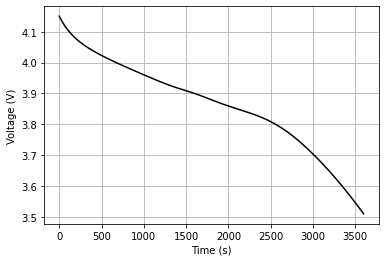

In [43]:
#  Define our time span and run the simulation
tspan = np.linspace(0, 3600, 100)
cc_sim = CC_ODE(tspan, -1)

#  Plot the results
plt.plot(cc_sim.t, cc_sim.V, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)

###  Constant Power - solve_ivp

Our constraint is $P_0 = IV = $ constant.

In [44]:
class CP_ODE:
    #  Set values of the resistances and capacitance
    R0 = 0.050
    R1 = 0.040
    C1 = 3000
    
    #  Set the cell capacity
    capacity = 1.5
    
    def __init__(self, tspan, P):
        self.P0 = P
        
        #  We now have two differential equations and need two initial values.  Both happen to be zero
        x0 = np.array([0, 0])
        
        #  Call the solver and store the results in class variables
        self.sol = solve_ivp(self.equations, (tspan[0], tspan[-1]), x0, t_eval = tspan)
        self.t = self.sol.t
        self.V_cap = self.sol.y[0,:]
        self.dod = self.sol.y[1,:]
        
        #  Lopp over the times and capacitor voltages and calculate the battery's voltage at each point.
        #  The results are stored in the list V.
        self.V = []
        i = 0
        for t in self.sol.t:
            y = fsolve(self.alg_system, [3, -1], args = (self.V_cap[i], t, self.dod[i]))
            self.V.append( y[0] )
            i = i + 1
        
    #  Define the differential equations    
    def equations(self, t, x):
            
        V_cap = x[0]
        dod = x[1]
        
        #  At each t, we need to calculate the current based on the constraint equation.
        y = fsolve(self.alg_system, [3, -1], args = (V_cap, t, dod))
        I = y[1]
            
        return( [- V_cap / (self.R1 * self.C1) - I / self.C1,
            -I  / 3600 / self.capacity] )
        
    #  This solves for our constraints  Returns the cell voltage and current based on time, dod, and the capacitor voltage.    
    def alg_system(self, x, V_cap, t, dod):
            
        res = np.zeros(2)
            
        V       = x[0]
        I  = x[1]
            
        U_ocp = V_ocp(dod)
            
        res[0] = -V +  U_ocp - V_cap + I * self.R0
        res[1] = I * V - self.P0
            
        return res
    
    

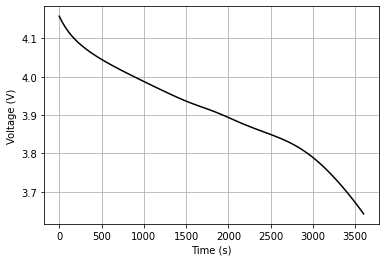

In [45]:
#  Define our time span and run the simulation
tspan = np.linspace(0, 3600, 100)
cp_sim = CP_ODE(tspan, -3.5)

#  Plot the results
plt.plot(cp_sim.t, cp_sim.V, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)

###  Constant Power - Assimulo

In [46]:
class CP_DAE:
    #  Set values of the resistances and capacitance
    R0 = 0.050
    R1 = 0.040
    C1 = 3000
    
    #  Set the cell capacity
    capacity = 1.5
    
    def  __init__(self, tspan, P):
        self.P0 = P
        
        #  Our guesses at initial conditions
        x0 = np.zeros( 4 )
        x0[0] = 0
        x0[1] = 3.5
        x0[2] = -1
        x0[3] = 0
        
        #  We also need the inital values of the derivatives.  These are unknown
        xprime0 = np.zeros( 4 )
        xprime0[0] = 0
        xprime0[1] = 0
        xprime0[2] = 0
        xprime0[3] = 0
        
        #  Start simulation at time equals zero.
        t0 = tspan[0]
        
        #  Switch vector and a vector saying which variables are differential or algebraic.
        sw0 = [False, False, False, False]
        algvar = [True, False, False, True]
        
        #  Create a problem object
        model = Implicit_Problem(self.equation, x0, xprime0, t0, sw0 = sw0)
        
        #  Create a solver, attach algvar.
        sim = IDA(model)
        sim.algvar = algvar
        
        #  Tell the solver to calculate consistant initial conditions.
        sim.make_consistent('IDA_YA_YDP_INIT')
        
        #  Run the simulation and bind the results to class variables.
        t, x, xp = sim.simulate(tspan[-1], 100)
        self.t = t
        self.x = x
        
        self.V = x[:,1]
    
    #  Our DAE system.  Has the form:
    #  0 = f(t, x, xprime, sw)
    def equation(self, t, x, xprime, sw):
        res = np.zeros(4)
        
        V_cap  = x[0]
        V = x[1]
        I = x[2]
        dod = x[3]
        
        U_ocp = V_ocp(dod)
        
        res[0] = -xprime[0] - V_cap / (self.R1 * self.C1) - I / self.C1
        res[1] = -V +  U_ocp - V_cap + I * self.R0
        res[2] = I * V - self.P0
        res[3] = xprime[3] - (-I  / 3600 / self.capacity)
        
        return res
        

In [47]:
#  Define the time span and run the simulation
tspan = np.linspace(0, 3600, 100)
dae_cp_sim = CP_DAE(tspan, -3.5)

Final Run Statistics: --- 

 Number of steps                                 : 113
 Number of function evaluations                  : 167
 Number of Jacobian evaluations                  : 24
 Number of function eval. due to Jacobian eval.  : 96
 Number of error test failures                   : 10
 Number of nonlinear iterations                  : 167
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 3600.0 seconds.
Elapsed simulation time: 0.006871699999919656 seconds.


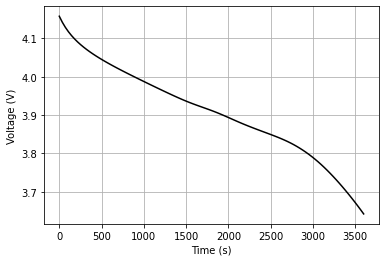

In [48]:
#  Plot the results
plt.plot(dae_cp_sim.t, dae_cp_sim.V, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)

###  Constant Current - Assimulo

In [49]:
class CC_DAE:
    #  Set values of the resistances and capacitance
    R0 = 0.050
    R1 = 0.040
    C1 = 3000
    
    #  Set the cell capacity
    capacity = 1.5
    
    def  __init__(self, tspan, I):
        self.I0 = I
        
        #Initial values
        x0 = np.zeros( 4 )
        x0[0] = 0
        x0[1] = 3.5
        x0[2] = -1
        x0[3] = 0
        
        xprime0 = np.zeros( 4 )
        xprime0[0] = 0
        xprime0[1] = 0
        xprime0[2] = 0
        xprime0[3] = 0
        
        t0 = tspan[0]
        
        #  Switch and algvar
        sw0 = [False, False, False, False]
        algvar = [True, False, False, True]
        
        model = Implicit_Problem(self.equation, x0, xprime0, t0, sw0 = sw0)
        
        sim = IDA(model)
        sim.algvar = algvar
        sim.make_consistent('IDA_YA_YDP_INIT')
        
        t, x, xp = sim.simulate(tspan[-1], 100)
        self.t = t
        self.x = x
        
        self.V = x[:,1]
        
    def equation(self, t, x, xprime, sw):
        res = np.zeros(4)
        
        V_cap  = x[0]
        V = x[1]
        I = x[2]
        dod = x[3]
        
        U_ocp = V_ocp(dod)
        
        res[0] = -xprime[0] - V_cap / (self.R1 * self.C1) - I / self.C1
        res[1] = -V +  U_ocp - V_cap + I * self.R0
        res[2] = I - self.I0
        res[3] = xprime[3] - (-I  / 3600 / self.capacity)
        
        return res
        

In [50]:
#  Define the time span and run the simultation
tspan = np.linspace(0, 3600, 100)
dae_cc_sim = CC_DAE(tspan, -1)

Final Run Statistics: --- 

 Number of steps                                 : 108
 Number of function evaluations                  : 176
 Number of Jacobian evaluations                  : 45
 Number of function eval. due to Jacobian eval.  : 180
 Number of error test failures                   : 17
 Number of nonlinear iterations                  : 176
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 3600.0 seconds.
Elapsed simulation time: 0.008230699999785429 seconds.


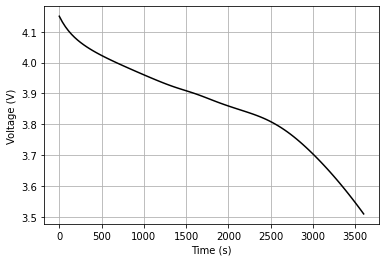

In [51]:
#  Plot the results
plt.plot(dae_cc_sim.t, dae_cc_sim.V, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)